In [1]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set_theme('notebook', style='whitegrid', font_scale=1.25)

# autoload changes in other files, so you don't have to restart the Jupyter kernel each time you make a change to the imported code.
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
from experimentloop2 import load_data, grid_search, PARAM_GRID, pipeline
from preprocessing import text_col, num_del, num_to_sp
from sklearn.pipeline import FunctionTransformer

In [4]:
x_NC, y_N = load_data()
param_grid = {
    "featurize__review_bow__token_pattern": [
        r"(?u)\b\w+\b",
        r"(?u)\b\w\w+\b",
        r"(?u)\b\w\w\w+\b",
        # r"(?u)\b\w\w\w\w+\b",
    ],
    "featurize__review_bow__strip_accents": ["unicode", None],
    "featurize__review_bow__lowercase": [True, False],
    "featurize__review_bow__min_df": [1, 2, 3],
    "featurize__review_bow__max_df": np.logspace(-2, 0, 11),
    #"classify__C": np.logspace(-5, 4, 19),
    "classify__C": np.logspace(-2, 2, 5),
}
search = grid_search(x_NC, y_N, param_grid, return_train_score=False)

In [6]:
print("best auroc: ", search.best_score_)
print("vocab size: ", len(search.best_estimator_.named_steps["featurize"].named_transformers_['review_bow'].vocabulary_))
print("best params: ", search.best_params_)

best auroc:  0.8875034722222221
vocab size:  4526
best params:  {'classify__C': 10.0, 'featurize__review_bow__lowercase': True, 'featurize__review_bow__max_df': 0.15848931924611143, 'featurize__review_bow__min_df': 1, 'featurize__review_bow__strip_accents': None, 'featurize__review_bow__token_pattern': '(?u)\\b\\w+\\b'}


In [37]:
param_grid_l2 = {k: [v] for k, v in search.best_params_.items()}
param_grid_l2_c = np.logspace(-5, 4, 55)
param_grid_l2['classify__C'] = param_grid_l2_c
search_l2 = grid_search(x_NC, y_N, param_grid_l2, return_train_score=True)

In [38]:
print("best auroc: ", search_l2.best_score_)
print("vocab size: ", len(search_l2.best_estimator_.named_steps["featurize"].named_transformers_['review_bow'].vocabulary_))
print("best params: ", search_l2.best_params_)

best auroc:  0.8886354166666667
vocab size:  4526
best params:  {'classify__C': 4.641588833612772, 'featurize__review_bow__lowercase': True, 'featurize__review_bow__max_df': 0.15848931924611143, 'featurize__review_bow__min_df': 1, 'featurize__review_bow__strip_accents': None, 'featurize__review_bow__token_pattern': '(?u)\\b\\w+\\b'}


In [30]:
param_grid_l1_c = np.logspace(-5, 4, 55)
param_grid_l1 = {k: [v] for k, v in search.best_params_.items()}
param_grid_l1["classify__penalty"] = ['l1']
param_grid_l1["classify__C"] = param_grid_l1_c
param_grid_l1["classify__solver"] = ['liblinear']
search_l1 = grid_search(x_NC, y_N, param_grid_l1, return_train_score=True)

/Users/theo/opt/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/theo/opt/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/theo/opt/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [31]:
print("best auroc: ", search_l1.best_score_)
print("vocab size: ", len(search_l1.best_estimator_.named_steps["featurize"].named_transformers_['review_bow'].vocabulary_))
print("best params: ", search_l1.best_params_)

best auroc:  0.8807934027777777
vocab size:  4526
best params:  {'classify__C': 3.1622776601683795, 'classify__penalty': 'l1', 'classify__solver': 'liblinear', 'featurize__review_bow__lowercase': True, 'featurize__review_bow__max_df': 0.15848931924611143, 'featurize__review_bow__min_df': 1, 'featurize__review_bow__strip_accents': None, 'featurize__review_bow__token_pattern': '(?u)\\b\\w+\\b'}


In [39]:
import pickle
def save_model_2(pipeline):
    featurizer = pipeline.steps[0][1]
    classifier = pipeline.steps[1][1]
    with open("problem2_featurizer.pickle", "wb") as f:
        pickle.dump(featurizer, f)
    with open("problem2_classifier.pickle", "wb") as f:
        pickle.dump(classifier, f)

save_model_2(search_l2.best_estimator_)

In [13]:
from sklearn.model_selection import StratifiedKFold

In [22]:
cv_fp = 0
cv_fn = 0
best_param = search_l2.best_params_
errs = pd.DataFrame().reindex(columns=x_NC.columns)
#predictions = pd.DataFrame().reindex(columns=y_N).rename({'is_positive_sentiment': 'predicted_sentiment_positive'})
for tix, vix in StratifiedKFold(n_splits=5).split(x_NC, y_N):
    p = pipeline()
    p.set_params(**best_param)
    x_train_NC = x_NC.iloc[tix]
    x_val_MC = x_NC.iloc[vix].copy()
    p.fit(x_train_NC, y_N.iloc[tix])
    yhat_val = p.predict(x_val_MC)
    y_val = y_N.iloc[vix]
    cv_fp += np.sum((yhat_val == 1) & (y_val == 0))
    cv_fn += np.sum((yhat_val == 0) & (y_val == 1))
    x_val_MC['true_sentiment_positive'] = y_val
    x_val_MC['predicted_sentiment_positive'] = yhat_val
    fold_errs = x_val_MC.where(yhat_val != y_val).dropna()
    errs = pd.concat((errs, fold_errs))
errs = errs.astype({'true_sentiment_positive': int, 'predicted_sentiment_positive': int})
(cv_fp, cv_fn)

(232, 218)

In [23]:
errs.to_csv('./problem2_best_cv_errors.csv')

In [26]:
def error_rate(fn, x=x_NC, e=errs):
    base_count = x[fn(x)].shape[0]
    error_count = e[fn(e)].shape[0]
    return error_count / base_count


In [27]:
print('global error rate: ', np.round(errs.shape[0] / x_NC.shape[0], 3))
negation_error_rate = error_rate(lambda df: df.text.str.contains(r"\bnot\b|n't\b"))
print('negation error rate: ', np.round(negation_error_rate, 3))

imdb_error_rate = error_rate(lambda df: df.website_name == 'imdb')
print('imdb error rate: ', np.round(imdb_error_rate, 3))

amazon_error_rate = error_rate(lambda df: df.website_name == 'amazon')
print('amazon error rate: ', np.round(amazon_error_rate, 3))

yelp_error_rate = error_rate(lambda df: df.website_name == 'yelp')
print('yelp error rate: ', np.round(yelp_error_rate, 3))

global error rate:  0.188
negation error rate:  0.223
imdb error rate:  0.218
amazon error rate:  0.175
yelp error rate:  0.17


Text(0.5, 0, '$\\log_{10} C$')

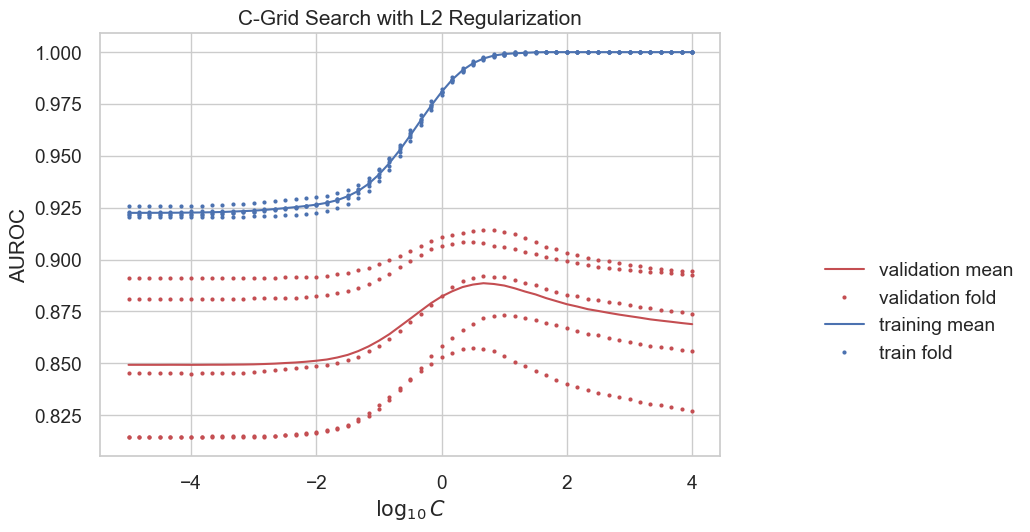

In [28]:
# first line: data points along C values for train performance
# second line: data points along C values for mean validation performance

c_grid_log = np.log10(param_grid_l2_c)
val_performance = search_l2.cv_results_['mean_test_score']
train_performance = search_l2.cv_results_['mean_train_score']

val_all_folds_performance = np.transpose([search_l2.cv_results_[f'split{k}_test_score'] for k in range(5)])
train_all_folds_performance = np.transpose([search_l2.cv_results_[f'split{k}_train_score'] for k in range(5)])

plt.title('C-Grid Search with L2 Regularization')
plt.plot(c_grid_log, val_performance, 'r-', label='validation mean')
plt.plot(c_grid_log, val_all_folds_performance, 'r.', label='validation fold')
plt.plot(c_grid_log, train_performance, 'b-', label='training mean')
plt.plot(c_grid_log, train_all_folds_performance, 'b.', label='train fold')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.5, 0.5))

plt.ylabel('AUROC')
plt.xlabel('$\log_{10} C$')

Text(0.5, 0, '$\\log_{10} C$')

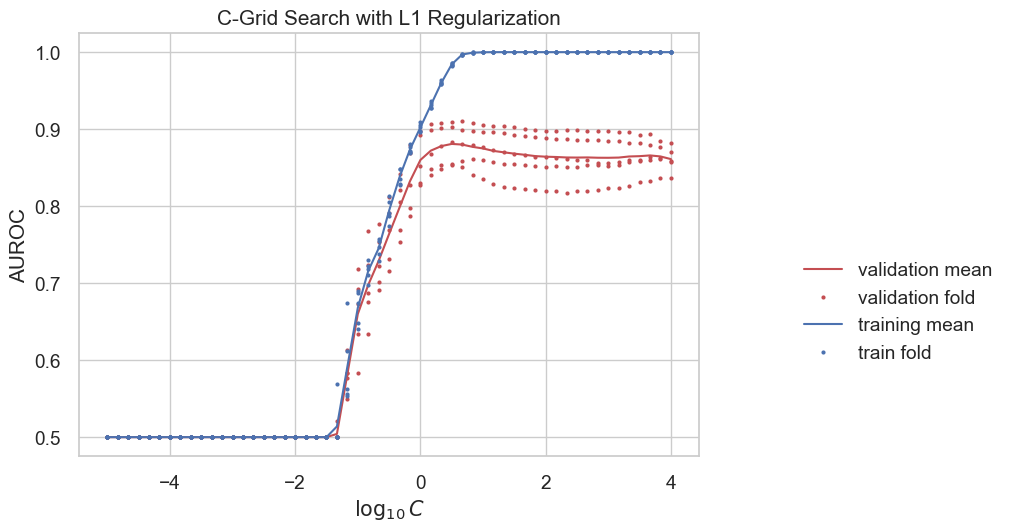

In [32]:

# first line: data points along C values for train performance
# second line: data points along C values for mean validation performance

c_grid_log = np.log10(param_grid_l1_c)
val_performance = search_l1.cv_results_['mean_test_score']
train_performance = search_l1.cv_results_['mean_train_score']

val_all_folds_performance = np.transpose([search_l1.cv_results_[f'split{k}_test_score'] for k in range(5)])
train_all_folds_performance = np.transpose([search_l1.cv_results_[f'split{k}_train_score'] for k in range(5)])

plt.title('C-Grid Search with L1 Regularization')
plt.plot(c_grid_log, val_performance, 'r-', label='validation mean')
plt.plot(c_grid_log, val_all_folds_performance, 'r.', label='validation fold')
plt.plot(c_grid_log, train_performance, 'b-', label='training mean')
plt.plot(c_grid_log, train_all_folds_performance, 'b.', label='train fold')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.5, 0.5))

plt.ylabel('AUROC')
plt.xlabel('$\log_{10} C$')